In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [2]:
dataset,info =tfds.load('glue/sst2' ,with_info=True)
print(info.features)

print(info.features['label'].num_classes)
print(info.features['label'].names)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteI6IEZ3/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteI6IEZ3/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteI6IEZ3/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [3]:
dataset_train,dataset_validation=dataset['train'],dataset['validation']

dataset_train

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [4]:
for example in dataset_train.take(2):
    review, label=example['sentence'], example['label']
    print("Review: " ,review)
    print("Label: %d" %label.numpy())
    print()

Review:  tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0

Review:  tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0



In [5]:
training_reviews=[]
training_labels=[]

validation_reviews=[]
validation_labels=[]

for item in dataset_train.take(-1):
    review,label = item['sentence'],item['label'] 
    training_reviews.append(str(review.numpy()))
    training_labels.append(label.numpy())

print("\n Number of Training reviews is: ",len(training_reviews))


for i in range(0,2):
    print(training_reviews[i])
    print(training_labels[i])

for item in dataset_validation.take(-1):
    review,label = item['sentence'],item['label'] 
    validation_reviews.append(str(review.numpy()))
    validation_labels.append(label.numpy())

print("\n Number of Training reviews is: ",len(validation_reviews))

  


 Number of Training reviews is:  67349
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

 Number of Training reviews is:  872


**Tokenize the words and sequence the sentences**

In [6]:
vocab_size=4000
embedding_dim=16
max_length=50
trunc_type='post'
padding_type='post'
oov_tok="<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(num_words=4000, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index



**Pad the Sequences**

In [7]:
training_sequences=tokenizer.texts_to_sequences(training_reviews)
training_padded=pad_sequences(training_sequences,maxlen=max_length,
                              truncating=trunc_type,
                              padding=padding_type)

validation_sequences=tokenizer.texts_to_sequences(validation_reviews)
validation_padded=pad_sequences(validation_sequences,maxlen=max_length,
                              truncating=trunc_type,
                              padding=padding_type)

training_labels_final=np.array(training_labels)
validation_labels_final=np.array(validation_labels)

**Creating the model using an Embedding**

In [8]:
model=tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length=max_length),
              tf.keras.layers.GlobalAveragePooling1D(),
              tf.keras.layers.Dense(6,activation='relu'),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 64,109
Trainable params: 64,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs=30
history=model.fit(training_padded,training_labels_final,
                  epochs=num_epochs,
                  validation_data=(validation_padded,validation_labels_final))

Epoch 1/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.5642 - accuracy: 0.7018 - val_loss: 0.4539 - val_accuracy: 0.8039
Epoch 2/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.3833 - accuracy: 0.8234 - val_loss: 0.4856 - val_accuracy: 0.7970
Epoch 3/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.3435 - accuracy: 0.8349 - val_loss: 0.5280 - val_accuracy: 0.7856
Epoch 4/30
2105/2105 [==============================] - 10s 5ms/step - loss: 0.3284 - accuracy: 0.8428 - val_loss: 0.5444 - val_accuracy: 0.7890
Epoch 5/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.3210 - accuracy: 0.8455 - val_loss: 0.5623 - val_accuracy: 0.7856
Epoch 6/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.3150 - accuracy: 0.8473 - val_loss: 0.5646 - val_accuracy: 0.7867
Epoch 7/30
2105/2105 [==============================] - 11s 5ms/step - loss: 0.3110 - accuracy: 0.8505 - val_loss: 0.5681 - val_ac

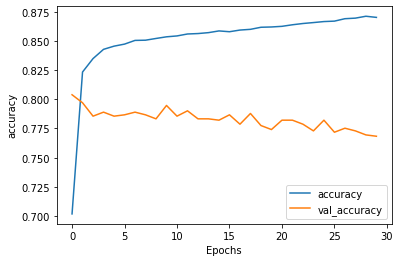

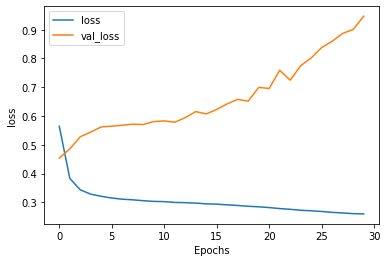

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
reviews1="I loved this movie"
reviews2="that was the worst movie I've ever seen"
reviews3="too much violence even for a Bond Film"
reviews4="a captivating recounting of a cherished myths"

new_reviews=[reviews1, reviews2 , reviews3 , reviews4]

In [13]:
def predict_review(model,reviews):
    padding_type="post"
    sample_sequences=tokenizer.texts_to_sequences(reviews)
    review_padded=pad_sequences(sample_sequences,maxlen=max_length,padding=padding_type)
    classes=model.predict(review_padded)

    for x in range(len(reviews)):
        print(reviews[x])
        print(classes[x])
        print()

predict_review(model,new_reviews)

I loved this movie
[0.99878246]

that was the worst movie I've ever seen
[0.00590857]

too much violence even for a Bond Film
[0.01523129]

a captivating recounting of a cherished myths
[0.9225624]



In [16]:
model_cnn=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Conv1D(128,5,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 75,149
Trainable params: 75,149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 12s 6ms/step - loss: 0.4859 - accuracy: 0.7519 - val_loss: 0

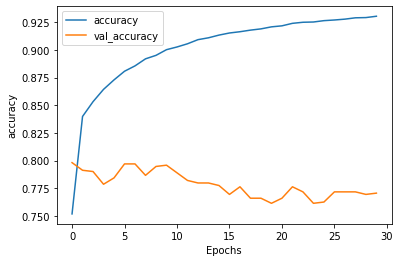

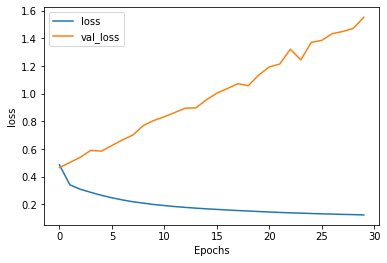

I loved this movie
[0.9999913]

that was the worst movie I've ever seen
[3.524681e-05]

too much violence even for a Bond Film
[0.12253091]

a captivating recounting of a cherished myths
[0.9999957]



In [17]:
model_cnn.summary()
history=model_cnn.fit(training_padded,training_labels_final,
                    epochs=num_epochs,
                    validation_data=(validation_padded,validation_labels_final))

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
predict_review(model_cnn,new_reviews)

In [21]:
model_gru=tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
              tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
              tf.keras.layers.Dense(6,activation='relu'),
              tf.keras.layers.Dense(1,activation='sigmoid')
])
model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 73,997
Trainable params: 73,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 49s 23ms/step - loss: 0.4246 - accuracy: 0.7844 - val_loss: 0.4276 - val_accuracy: 0.8108
Epoch 2/30
2105/2105 [==============================] - 48s 23ms/step - loss: 0.3163 - accuracy: 0.847

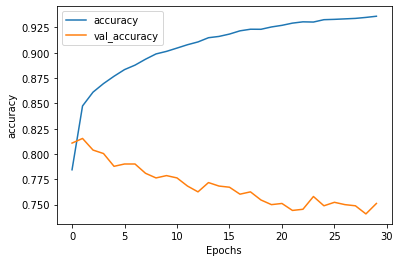

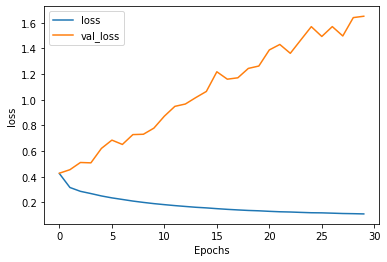

I loved this movie
[1.]

that was the worst movie I've ever seen
[2.6068146e-06]

too much violence even for a Bond Film
[0.49273545]

a captivating recounting of a cherished myths
[0.9999995]



In [22]:
model_gru.summary()
history=model_gru.fit(training_padded,training_labels_final,
                    epochs=num_epochs,
                    validation_data=(validation_padded,validation_labels_final))

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
predict_review(model_gru,new_reviews)

In [25]:
model_bidi_lstm=tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
              tf.keras.layers.Dense(6,activation='relu'),
              tf.keras.layers.Dense(1,activation='sigmoid')
])
model_bidi_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 68,429
Trainable params: 68,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 47s 23ms/step - loss: 0.4369 - accuracy: 0.7786 - val_loss: 0.4749 - val_accuracy: 0.8085
Epoch 2/30
2105/2105 [==============================] - 47s 22ms/step - loss: 0.3290 - accuracy: 0.843

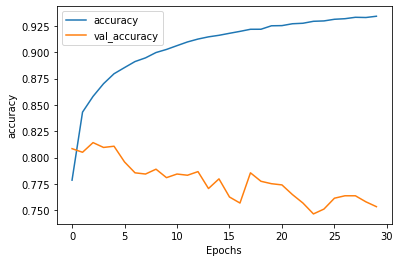

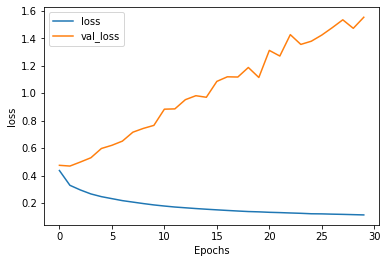

I loved this movie
[0.9995623]

that was the worst movie I've ever seen
[0.00055867]

too much violence even for a Bond Film
[1.0863686e-06]

a captivating recounting of a cherished myths
[0.999749]



In [26]:
model_bidi_lstm.summary()
history=model_bidi_lstm.fit(training_padded,training_labels_final,
                    epochs=num_epochs,
                    validation_data=(validation_padded,validation_labels_final))

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
predict_review(model_bidi_lstm,new_reviews)


In [28]:
model_multi_bidi_lstm=tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,return_sequences=True)),
              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
              tf.keras.layers.Dense(6,activation='relu'),
              tf.keras.layers.Dense(1,activation='sigmoid')
])
model_multi_bidi_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 74,701
Trainable params: 74,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 101s 48ms/step - loss: 0.4760 - accuracy: 0.7705 - val_loss:

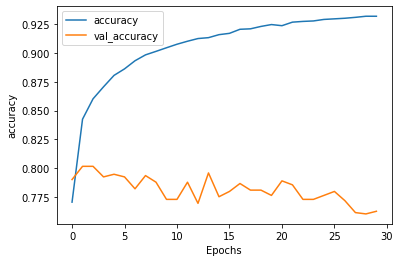

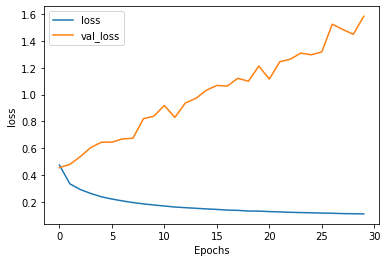

I loved this movie
[0.99999666]

that was the worst movie I've ever seen
[9.273214e-06]

too much violence even for a Bond Film
[0.00015981]

a captivating recounting of a cherished myths
[0.9999993]



In [29]:
model_multi_bidi_lstm.summary()
history=model_multi_bidi_lstm.fit(training_padded,training_labels_final,
                    epochs=num_epochs,
                    validation_data=(validation_padded,validation_labels_final))

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
predict_review(model_multi_bidi_lstm,new_reviews)


In [30]:
model.save('model_embedding.h5')

In [31]:
model_cnn.save('model_cnn.h5')

In [32]:
model_gru.save('model_gru.h5')

In [33]:
model_bidi_lstm.save('model_bidi_lstm.h5')

In [34]:
model_multi_bidi_lstm.save('model_multi_bidi_lstm.h5')

In [35]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (29.2 MB/s)
debconf: unable to initia

In [36]:

import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [38]:
path='/content/drive/My Drive/Dataset'
test_data=[]
m=dict()
for files in os.listdir(path):
    image_path_in_colab=os.path.join(path,files)
    extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
    test_data.append(extractedInformation)
    m[files]=test_data[-1]

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [42]:
tokenizer=Tokenizer(num_words=4000,oov_token='<OOV>')
tokenizer.fit_on_texts(test_data)

word_index=tokenizer.word_index

In [43]:
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(test_data)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type)

classes = model.predict(fakes_padded)

In [44]:
import pandas as pd
test=pd.read_csv('/content/drive/My Drive/Test.csv')
test.head()

,Filename,Category
0,Test1001.jpg,NaN
1,Test1012.jpg,NaN
2,Test1022.jpg,NaN
3,Test1071.jpg,NaN
4,Test1122.jpg,NaN


In [45]:
test_dataset=[]
for i in range(len(test)):
    test_dataset.append(m[test['Filename'][i]])

In [51]:
i=0

for files in os.listdir(path):
  if(test_data[i]==""):
    m[files]=2
  elif (classes[i] > 0.4):
    m[files]=1
  else:
    m[files]=0
  i+=1

data=["Negative" ,"Positive" , "Random"]


m1=dict()
for i in range(len(test)):
  m1[test['Filename'][i]]=data[m[test['Filename'][i]]]


df = pd.DataFrame(list(m1.items()),columns = ['Filename','Category']) 

df.to_csv('submission_embedding.csv',index=False)

In [49]:
df.head()

,Filename,Category
0,Test1001.jpg,Positive
1,Test1012.jpg,Positive
2,Test1022.jpg,Positive
3,Test1071.jpg,Negative
4,Test1122.jpg,Positive


In [52]:
classes = model_cnn.predict(fakes_padded)

test_dataset=[]
for i in range(len(test)):
    test_dataset.append(m[test['Filename'][i]])
  
i=0
m=dict()
for files in os.listdir(path):
  if(test_data[i]==""):
    m[files]=2
  elif (classes[i] > 0.4):
    m[files]=1
  else:
    m[files]=0
  i+=1

data=["Negative" ,"Positive" , "Random"]


m1=dict()
for i in range(len(test)):
  m1[test['Filename'][i]]=data[m[test['Filename'][i]]]


df = pd.DataFrame(list(m1.items()),columns = ['Filename','Category']) 

df.to_csv('submission_cnn.csv',index=False)

In [54]:
classes = model_gru.predict(fakes_padded)

test_dataset=[]
for i in range(len(test)):
    test_dataset.append(m[test['Filename'][i]])
  
i=0
m=dict()
for files in os.listdir(path):
  if(test_data[i]==""):
    m[files]=2
  elif (classes[i] > 0.3):
    m[files]=1
  else:
    m[files]=0
  i+=1

data=["Negative" ,"Positive" , "Random"]


m1=dict()
for i in range(len(test)):
  m1[test['Filename'][i]]=data[m[test['Filename'][i]]]


df = pd.DataFrame(list(m1.items()),columns = ['Filename','Category']) 

df.to_csv('submission_gru.csv',index=False)

In [56]:
classes = model_bidi_lstm.predict(fakes_padded)

test_dataset=[]
for i in range(len(test)):
    test_dataset.append(m[test['Filename'][i]])
  
i=0
m=dict()
for files in os.listdir(path):
  if(test_data[i]==""):
    m[files]=2
  elif (classes[i] > 0.3):
    m[files]=1
  else:
    m[files]=0
  i+=1

data=["Negative" ,"Positive" , "Random"]


m1=dict()
for i in range(len(test)):
  m1[test['Filename'][i]]=data[m[test['Filename'][i]]]


df = pd.DataFrame(list(m1.items()),columns = ['Filename','Category']) 

df.to_csv('submission_bidi.csv',index=False)

In [58]:
classes = model_multi_bidi_lstm.predict(fakes_padded)

test_dataset=[]
for i in range(len(test)):
    test_dataset.append(m[test['Filename'][i]])
  
i=0
m=dict()
for files in os.listdir(path):
  if(test_data[i]==""):
    m[files]=2
  elif (classes[i] > 0.3):
    m[files]=1
  else:
    m[files]=0
  i+=1

data=["Negative" ,"Positive" , "Random"]


m1=dict()
for i in range(len(test)):
  m1[test['Filename'][i]]=data[m[test['Filename'][i]]]


df = pd.DataFrame(list(m1.items()),columns = ['Filename','Category']) 

df.to_csv('submission_multi_bidi.csv',index=False)